# #########################################
# PIP INSTALLING ALL THE NECESARY PACKAGES
# #########################################

In [3]:
pip install tensorflow scikit-learn matplotlib numpy pandas xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 7.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 6.3 MB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


# ##################################################
# IMAGE PREPROCESSING - CLAHE, GAUSSIAN BLUR AND B/W
# ##################################################

In [1]:
import os
import cv2
import numpy as np

# === Paths ===
input_dir = './augmented_resized_V2/train'     # CHANGE THIS
output_dir = './preprocessed_train'            # NEW preprocessed output

os.makedirs(output_dir, exist_ok=True)

# === Preprocessing Function ===
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    # Gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Resize (if needed)
    gray = cv2.resize(gray, (384, 384))

    return gray

# === Process All Images ===
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            in_path = os.path.join(class_path, fname)
            out_path = os.path.join(output_class_path, fname)

            try:
                processed = preprocess_image(in_path)
                cv2.imwrite(out_path, processed)
            except Exception as e:
                print(f"❌ Failed to process {in_path}: {e}")


CLAHE

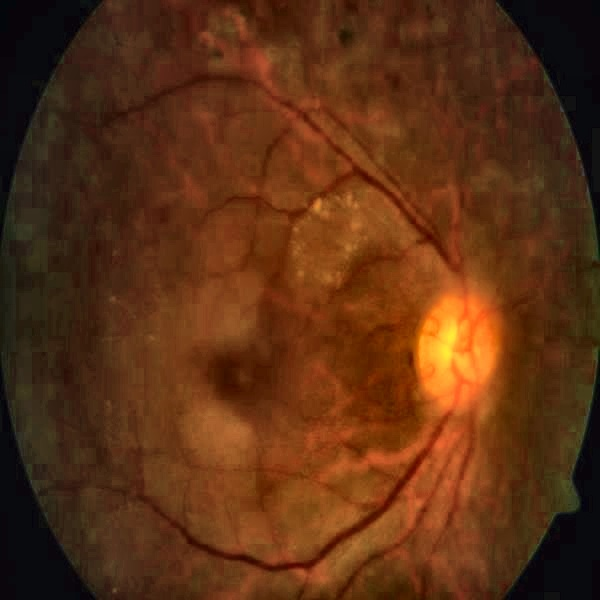


GAUSSIAN BLUR

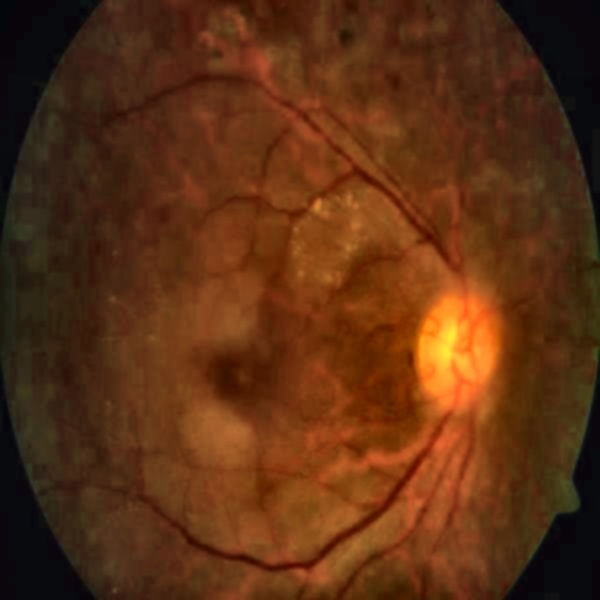


BLACK AND WHITE

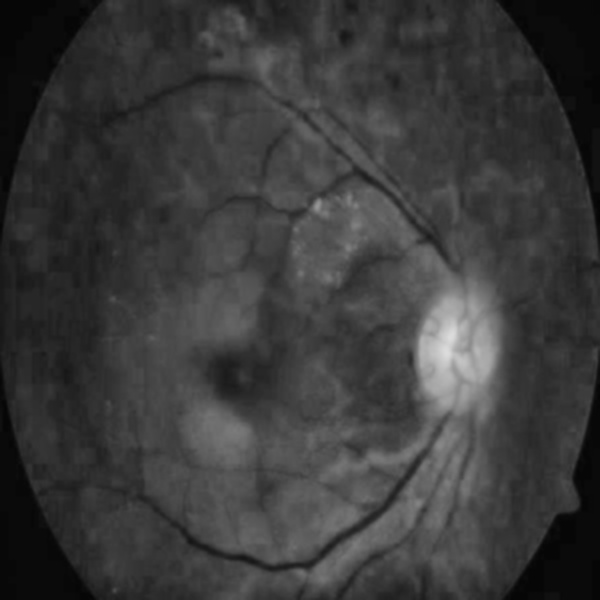


# ############################
# NEW RUN - EFFICIENTNETB3
# ############################

In [1]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# === Paths ===
train_dir = './augmented_resized_V2/train'
val_dir = './augmented_resized_V2/val'
output_path = './combinedOUTPUT_dir'
os.makedirs(output_path, exist_ok=True)
model_name = 'effnetb3_img384'
weights_path = os.path.join(output_path, f'{model_name}_best.h5')

# === Constants ===
IMG_SIZE = 384
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 15
NUM_CLASSES = 5

# === Class weights (from training distribution) ===
class_weight = {
    0: 0.75,
    1: 0.81,
    2: 0.79,
    3: 1.88,
    4: 1.58
}

# === Image Generators ===
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# === Model Definition ===
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# === Callbacks ===
callbacks = [
    ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.2, verbose=1)
]

# === Phase 1: Train top head ===
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("🔒 Phase 1: Training head (base frozen)")
model.fit(
    train_data,
    epochs=EPOCHS_PHASE1,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight
)

# === Phase 2: Fine-tune last 100 layers ===
print("🔓 Phase 2: Fine-tuning last 100 layers")
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_data,
    epochs=EPOCHS_PHASE2,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight
)

# === Evaluation ===
print("🧪 Evaluating on validation set...")
val_data.reset()
preds = model.predict(val_data, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

print("🌀 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


2025-04-13 05:22:02.034259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744521722.188505    1614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744521722.233927    1614 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744521722.565283    1614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744521722.565396    1614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744521722.565399    1614 computation_placer.cc:177] computation placer alr

Found 74881 images belonging to 5 classes.
Found 9708 images belonging to 5 classes.


I0000 00:00:1744521749.741994    1614 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


🔒 Phase 1: Training head (base frozen)


/home/rithish0227/jaienv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1744521773.010181    6263 service.cc:152] XLA service 0x7f38c8001e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744521773.010239    6263 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-13 05:22:53.647570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744521777.098557    6263 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-13 05:23:08.854582: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try sma

 293/2341 ━━━━━━━━━━━━━━━━━━━━ 9:02 265ms/step - accuracy: 0.1821 - loss: 1.6669

2025-04-13 05:25:21.045177: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.205 = (f32[1,288,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,288,48,48]{3,2,1,0} %bitcast.54147, f32[288,1,5,5]{3,2,1,0} %bitcast.54154), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=288, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_1/block3b_dwconv_1/depthwise" source_file="/home/rithish0227/jaienv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-13 05:25:21.293236: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.248236811s
Trying algorithm

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.1953 - loss: 1.6510

2025-04-13 05:34:26.586627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3266', 76 bytes spill stores, 76 bytes spill loads

2025-04-13 05:34:26.854494: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3266', 212 bytes spill stores, 212 bytes spill loads

2025-04-13 05:34:30.189070: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3266', 3816 bytes spill stores, 3796 bytes spill loads

2025-04-13 05:34:30.277072: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3266', 4168 bytes spill stores, 4152 bytes spill loads

2025-04-13 05:35:54.617649: I 

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 832s 322ms/step - accuracy: 0.1953 - loss: 1.6510 - val_accuracy: 0.2578 - val_loss: 1.5993 - learning_rate: 0.0010
Epoch 2/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 659s 281ms/step - accuracy: 0.2019 - loss: 1.6390 - val_accuracy: 0.1897 - val_loss: 1.6037 - learning_rate: 0.0010
Epoch 3/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 656s 280ms/step - accuracy: 0.2000 - loss: 1.6412 - val_accuracy: 0.1897 - val_loss: 1.6495 - learning_rate: 0.0010
Epoch 4/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 675s 288ms/step - accuracy: 0.2071 - loss: 1.6302 - val_accuracy: 0.2367 - val_loss: 1.6183 - learning_rate: 0.0010
Epoch 5/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.2031 - loss: 1.6354
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 653s 279ms/step - accuracy: 0.2031 - loss: 1.6354 - val_accuracy: 0.2650 - val_loss: 1.6265 - learning_rate: 0.0010
Epoch 6/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accurac

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 644s 275ms/step - accuracy: 0.2096 - loss: 1.6232 - val_accuracy: 0.2671 - val_loss: 1.5798 - learning_rate: 2.0000e-04
Epoch 7/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 646s 276ms/step - accuracy: 0.2042 - loss: 1.6198 - val_accuracy: 0.2991 - val_loss: 1.5981 - learning_rate: 2.0000e-04
Epoch 8/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2006 - loss: 1.6187

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 651s 276ms/step - accuracy: 0.2006 - loss: 1.6187 - val_accuracy: 0.3055 - val_loss: 1.5780 - learning_rate: 2.0000e-04
Epoch 9/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 645s 276ms/step - accuracy: 0.2048 - loss: 1.6162 - val_accuracy: 0.2587 - val_loss: 1.5922 - learning_rate: 2.0000e-04
Epoch 10/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2123 - loss: 1.6112

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 647s 276ms/step - accuracy: 0.2123 - loss: 1.6112 - val_accuracy: 0.2985 - val_loss: 1.5627 - learning_rate: 2.0000e-04
🔓 Phase 2: Fine-tuning last 100 layers
Epoch 1/15


2025-04-13 07:15:20.312445: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-13 07:15:20.320721: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng18{k11=2} for conv %cudnn-conv-bw-filter.22 = (f32[1392,1,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1392,12,12]{3,2,1,0} %bitcast.88121, f32[32,1392,12,12]{3,2,1,0} %bitcast.88123), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=1392, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="DepthwiseConv2dNativeBackpropFilter" op_name="gradient_tape/functional_1/block6c_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropFilter" source_file="/home/rithish0227/jaienv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 977s 379ms/step - accuracy: 0.2046 - loss: 1.6307 - val_accuracy: 0.2609 - val_loss: 1.5817 - learning_rate: 1.0000e-05
Epoch 2/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 839s 358ms/step - accuracy: 0.2238 - loss: 1.6044 - val_accuracy: 0.2664 - val_loss: 1.5827 - learning_rate: 1.0000e-05
Epoch 3/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 836s 357ms/step - accuracy: 0.2277 - loss: 1.5994 - val_accuracy: 0.2700 - val_loss: 1.5945 - learning_rate: 1.0000e-05
Epoch 4/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2338 - loss: 1.5896

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 843s 360ms/step - accuracy: 0.2338 - loss: 1.5896 - val_accuracy: 0.2765 - val_loss: 1.5554 - learning_rate: 1.0000e-05
Epoch 5/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 851s 363ms/step - accuracy: 0.2369 - loss: 1.5928 - val_accuracy: 0.2898 - val_loss: 1.5556 - learning_rate: 1.0000e-05
Epoch 6/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 846s 361ms/step - accuracy: 0.2408 - loss: 1.5883 - val_accuracy: 0.2773 - val_loss: 1.5607 - learning_rate: 1.0000e-05
Epoch 7/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2455 - loss: 1.5887

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 851s 363ms/step - accuracy: 0.2455 - loss: 1.5887 - val_accuracy: 0.2804 - val_loss: 1.5525 - learning_rate: 1.0000e-05
Epoch 8/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2440 - loss: 1.5867

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 853s 364ms/step - accuracy: 0.2440 - loss: 1.5867 - val_accuracy: 0.3293 - val_loss: 1.5346 - learning_rate: 1.0000e-05
Epoch 9/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 847s 362ms/step - accuracy: 0.2512 - loss: 1.5831 - val_accuracy: 0.2919 - val_loss: 1.5389 - learning_rate: 1.0000e-05
Epoch 10/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 849s 363ms/step - accuracy: 0.2573 - loss: 1.5776 - val_accuracy: 0.2809 - val_loss: 1.5804 - learning_rate: 1.0000e-05
Epoch 11/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 852s 364ms/step - accuracy: 0.2596 - loss: 1.5750 - val_accuracy: 0.2425 - val_loss: 1.5939 - learning_rate: 1.0000e-05
Epoch 12/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2624 - loss: 1.5740
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 851s 364ms/step - accuracy: 0.2624 - loss: 1.5740 - val_accuracy: 0.2973 - val_loss: 1.5397 - learning_rate: 1.0000e-05
Epoch 13/15
2341/2341 ━━━━━━━━━━━━━━━━━━━

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 850s 363ms/step - accuracy: 0.2636 - loss: 1.5656 - val_accuracy: 0.3206 - val_loss: 1.5315 - learning_rate: 2.0000e-06
Epoch 14/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 847s 362ms/step - accuracy: 0.2796 - loss: 1.5581 - val_accuracy: 0.2674 - val_loss: 1.5772 - learning_rate: 2.0000e-06
Epoch 15/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2728 - loss: 1.5638

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 850s 363ms/step - accuracy: 0.2728 - loss: 1.5638 - val_accuracy: 0.3293 - val_loss: 1.5259 - learning_rate: 2.0000e-06
🧪 Evaluating on validation set...
304/304 ━━━━━━━━━━━━━━━━━━━━ 113s 324ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.44      0.43      2900
           1       0.43      0.10      0.16      1840
           2       0.29      0.45      0.35      2500
           3       0.19      0.18      0.18      1000
           4       0.31      0.30      0.31      1468

    accuracy                           0.33      9708
   macro avg       0.33      0.29      0.29      9708
weighted avg       0.35      0.33      0.31      9708

🌀 Confusion Matrix:
[[1271   76 1275   77  201]
 [ 523  186  636  218  277]
 [ 761   41 1119  228  351]
 [ 234   53  370  176  167]
 [ 193   73  519  238  445]]


# ############################
# NEW RUN - RESNET50
# ############################

In [1]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# === Paths ===
train_dir = './augmented_resized_V2/train'
val_dir = './augmented_resized_V2/val'
output_path = './combinedOUTPUT_dir'
os.makedirs(output_path, exist_ok=True)
model_name = 'resnet50_img384'
weights_path = os.path.join(output_path, f'{model_name}_best.h5')

# === Constants ===
IMG_SIZE = 384
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 15
NUM_CLASSES = 5

# === Class Weights ===
class_weight = {
    0: 0.75,
    1: 0.81,
    2: 0.79,
    3: 1.88,
    4: 1.58
}

# === Data Generators ===
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# === Model ===
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# === Callbacks ===
callbacks = [
    ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# === Phase 1: Train Classifier Head ===
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("🔒 Phase 1: Training ResNet50 head (base frozen)")
model.fit(
    train_data,
    epochs=EPOCHS_PHASE1,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight
)

# === Phase 2: Fine-tune Last 100 Layers ===
print("🔓 Phase 2: Fine-tuning last 100 layers")
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_data,
    epochs=EPOCHS_PHASE2,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight
)

# === Evaluation ===
print("🧪 Evaluating on validation set...")
val_data.reset()
preds = model.predict(val_data, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

print("🌀 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


2025-04-13 13:55:28.859575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744552528.997042   24979 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744552529.037397   24979 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744552529.328587   24979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744552529.328622   24979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744552529.328625   24979 computation_placer.cc:177] computation placer alr

Found 74881 images belonging to 5 classes.
Found 9708 images belonging to 5 classes.


I0000 00:00:1744552552.553287   24979 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


🔒 Phase 1: Training ResNet50 head (base frozen)


/home/rithish0227/jaienv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1744552563.397284   25195 service.cc:152] XLA service 0x7f01740028f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744552563.397360   25195 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-13 13:56:03.659402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744552565.530075   25195 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1744552578.312335   25195 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2022 - loss: 1.7745

2025-04-13 14:07:23.072421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 212 bytes spill stores, 212 bytes spill loads

2025-04-13 14:07:23.353387: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 76 bytes spill stores, 76 bytes spill loads

2025-04-13 14:07:24.137523: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 3816 bytes spill stores, 3796 bytes spill loads

2025-04-13 14:07:24.329845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 4168 bytes spill stores, 4152 bytes spill loads

2025-04-13 14:08:51.874574: I 

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 783s 325ms/step - accuracy: 0.2022 - loss: 1.7745 - val_accuracy: 0.1666 - val_loss: 1.6093 - learning_rate: 0.0010
Epoch 2/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 745s 318ms/step - accuracy: 0.2127 - loss: 1.6596 - val_accuracy: 0.3127 - val_loss: 1.6382 - learning_rate: 0.0010
Epoch 3/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 745s 318ms/step - accuracy: 0.2287 - loss: 1.6483 - val_accuracy: 0.2028 - val_loss: 1.6409 - learning_rate: 0.0010
Epoch 4/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 748s 319ms/step - accuracy: 0.2303 - loss: 1.6426 - val_accuracy: 0.2127 - val_loss: 1.6566 - learning_rate: 0.0010
Epoch 5/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2304 - loss: 1.6402
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 748s 319ms/step - accuracy: 0.2304 - loss: 1.6402 - val_accuracy: 0.1482 - val_loss: 1.6641 - learning_rate: 0.0010
Epoch 6/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accurac

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 750s 320ms/step - accuracy: 0.2392 - loss: 1.5987 - val_accuracy: 0.3466 - val_loss: 1.5630 - learning_rate: 2.0000e-04
Epoch 7/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2518 - loss: 1.5825

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 748s 319ms/step - accuracy: 0.2518 - loss: 1.5825 - val_accuracy: 0.2978 - val_loss: 1.5587 - learning_rate: 2.0000e-04
Epoch 8/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 748s 319ms/step - accuracy: 0.2549 - loss: 1.5813 - val_accuracy: 0.1532 - val_loss: 1.6290 - learning_rate: 2.0000e-04
Epoch 9/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 749s 320ms/step - accuracy: 0.2544 - loss: 1.5853 - val_accuracy: 0.2281 - val_loss: 1.5801 - learning_rate: 2.0000e-04
Epoch 10/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2550 - loss: 1.5813

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 751s 321ms/step - accuracy: 0.2550 - loss: 1.5813 - val_accuracy: 0.3498 - val_loss: 1.5316 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 10.
🔓 Phase 2: Fine-tuning last 100 layers
Epoch 1/15


2025-04-13 16:01:48.445392: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2025-04-13 16:01:49.445535: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng18{k11=2} for conv %cudnn-conv-bw-filter.30 = (f32[512,128,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,48,48]{3,2,1,0} %bitcast.38017, f32[32,512,48,48]{3,2,1,0} %bitcast.38071), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_t

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1505s 620ms/step - accuracy: 0.2677 - loss: 2.9933 - val_accuracy: 0.2092 - val_loss: 2.0918 - learning_rate: 1.0000e-05
Epoch 2/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.4113 - loss: 1.3694

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1434s 612ms/step - accuracy: 0.4113 - loss: 1.3694 - val_accuracy: 0.4731 - val_loss: 1.3093 - learning_rate: 1.0000e-05
Epoch 3/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.4602 - loss: 1.2735

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1417s 605ms/step - accuracy: 0.4602 - loss: 1.2735 - val_accuracy: 0.4395 - val_loss: 1.3010 - learning_rate: 1.0000e-05
Epoch 4/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1410s 602ms/step - accuracy: 0.4981 - loss: 1.1972 - val_accuracy: 0.3828 - val_loss: 1.5284 - learning_rate: 1.0000e-05
Epoch 5/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5262 - loss: 1.1188

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1408s 601ms/step - accuracy: 0.5262 - loss: 1.1188 - val_accuracy: 0.5475 - val_loss: 1.1396 - learning_rate: 1.0000e-05
Epoch 6/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1400s 598ms/step - accuracy: 0.5547 - loss: 1.0439 - val_accuracy: 0.4966 - val_loss: 1.1892 - learning_rate: 1.0000e-05
Epoch 7/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1398s 597ms/step - accuracy: 0.5872 - loss: 0.9676 - val_accuracy: 0.5473 - val_loss: 1.2977 - learning_rate: 1.0000e-05
Epoch 8/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1397s 597ms/step - accuracy: 0.6208 - loss: 0.8685 - val_accuracy: 0.3393 - val_loss: 1.9066 - learning_rate: 1.0000e-05
Epoch 9/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6590 - loss: 0.7728
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 1395s 596ms/step - accuracy: 0.6590 - loss: 0.7728 - val_accuracy: 0.4747 - val_loss: 1.3260 - learning_rate: 1.0000e-05
Epoch 10/15
2341/2341 ━━━━━━━━━━━━━━━━━━

# ############################
# NEW RUN - DENSENET121
# ############################

In [1]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# === Paths ===
train_dir = './augmented_resized_V2/train'
val_dir = './augmented_resized_V2/val'
output_path = './combinedOUTPUT_dir'
os.makedirs(output_path, exist_ok=True)
model_name = 'densenet121_img384'
weights_path = os.path.join(output_path, f'{model_name}_best.h5')

# === Constants ===
IMG_SIZE = 384
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 15
NUM_CLASSES = 5

# === Class Weights ===
class_weight = {
    0: 0.75,
    1: 0.81,
    2: 0.79,
    3: 1.88,
    4: 1.58
}

# === Data Generators ===
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# === Model ===
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# === Callbacks ===
callbacks = [
    ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# === Phase 1: Train Classifier Head ===
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("🔒 Phase 1: Training DenseNet121 head (base frozen)")
model.fit(
    train_data,
    epochs=EPOCHS_PHASE1,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight
)

# === Phase 2: Fine-tune Last 100 Layers ===
print("🔓 Phase 2: Fine-tuning last 100 layers")
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_data,
    epochs=EPOCHS_PHASE2,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weight
)

# === Evaluation ===
print("🧪 Evaluating on validation set...")
val_data.reset()
preds = model.predict(val_data, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

print("🌀 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


2025-04-13 21:57:39.376867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744581459.455785   44603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744581459.478860   44603 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744581459.587665   44603 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744581459.587700   44603 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744581459.587703   44603 computation_placer.cc:177] computation placer alr

Found 74881 images belonging to 5 classes.
Found 9708 images belonging to 5 classes.


I0000 00:00:1744581485.909011   44603 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


🔒 Phase 1: Training DenseNet121 head (base frozen)


/home/rithish0227/jaienv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1744581504.210301   44797 service.cc:152] XLA service 0x7fd86021d590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744581504.210553   44797 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-13 21:58:24.738044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744581508.638093   44797 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1744581547.113572   44797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3552 - loss: 1.4735

2025-04-13 22:09:30.900120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3316', 212 bytes spill stores, 212 bytes spill loads

2025-04-13 22:09:31.182163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3316', 76 bytes spill stores, 76 bytes spill loads

2025-04-13 22:09:31.950388: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3316', 3748 bytes spill stores, 3744 bytes spill loads

2025-04-13 22:09:32.045303: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3316', 3980 bytes spill stores, 3960 bytes spill loads

2025-04-13 22:10:57.216169: I 

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 793s 314ms/step - accuracy: 0.3552 - loss: 1.4735 - val_accuracy: 0.5233 - val_loss: 1.1949 - learning_rate: 0.0010
Epoch 2/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4283 - loss: 1.3034

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 675s 288ms/step - accuracy: 0.4283 - loss: 1.3034 - val_accuracy: 0.5473 - val_loss: 1.1457 - learning_rate: 0.0010
Epoch 3/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 672s 287ms/step - accuracy: 0.4356 - loss: 1.2964 - val_accuracy: 0.5194 - val_loss: 1.1737 - learning_rate: 0.0010
Epoch 4/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 673s 287ms/step - accuracy: 0.4364 - loss: 1.2934 - val_accuracy: 0.4978 - val_loss: 1.2082 - learning_rate: 0.0010
Epoch 5/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 673s 288ms/step - accuracy: 0.4427 - loss: 1.2841 - val_accuracy: 0.5461 - val_loss: 1.1544 - learning_rate: 0.0010
Epoch 6/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.4359 - loss: 1.2965
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 672s 287ms/step - accuracy: 0.4359 - loss: 1.2965 - val_accuracy: 0.5041 - val_loss: 1.1893 - learning_rate: 0.0010
Epoch 7/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accurac

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 672s 287ms/step - accuracy: 0.4478 - loss: 1.2658 - val_accuracy: 0.5498 - val_loss: 1.1373 - learning_rate: 2.0000e-04
Epoch 8/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 672s 287ms/step - accuracy: 0.4578 - loss: 1.2557 - val_accuracy: 0.5293 - val_loss: 1.1763 - learning_rate: 2.0000e-04
Epoch 9/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 672s 287ms/step - accuracy: 0.4547 - loss: 1.2601 - val_accuracy: 0.5374 - val_loss: 1.1545 - learning_rate: 2.0000e-04
Epoch 10/10
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 670s 286ms/step - accuracy: 0.4589 - loss: 1.2513 - val_accuracy: 0.5450 - val_loss: 1.1450 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 7.
🔓 Phase 2: Fine-tuning last 100 layers
Epoch 1/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3713 - loss: 2.3818

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 873s 343ms/step - accuracy: 0.3713 - loss: 2.3816 - val_accuracy: 0.5850 - val_loss: 1.0773 - learning_rate: 1.0000e-05
Epoch 2/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.4676 - loss: 1.5803

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 738s 315ms/step - accuracy: 0.4676 - loss: 1.5803 - val_accuracy: 0.6121 - val_loss: 1.0087 - learning_rate: 1.0000e-05
Epoch 3/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.4948 - loss: 1.4380

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 741s 316ms/step - accuracy: 0.4948 - loss: 1.4379 - val_accuracy: 0.6346 - val_loss: 0.9660 - learning_rate: 1.0000e-05
Epoch 4/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5198 - loss: 1.3252

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 735s 314ms/step - accuracy: 0.5198 - loss: 1.3252 - val_accuracy: 0.6358 - val_loss: 0.9448 - learning_rate: 1.0000e-05
Epoch 5/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5312 - loss: 1.2445

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 743s 317ms/step - accuracy: 0.5312 - loss: 1.2445 - val_accuracy: 0.6430 - val_loss: 0.9432 - learning_rate: 1.0000e-05
Epoch 6/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5576 - loss: 1.1643

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 744s 318ms/step - accuracy: 0.5576 - loss: 1.1643 - val_accuracy: 0.6509 - val_loss: 0.9196 - learning_rate: 1.0000e-05
Epoch 7/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 744s 318ms/step - accuracy: 0.5700 - loss: 1.1153 - val_accuracy: 0.6461 - val_loss: 0.9322 - learning_rate: 1.0000e-05
Epoch 8/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 746s 319ms/step - accuracy: 0.5902 - loss: 1.0402 - val_accuracy: 0.6501 - val_loss: 0.9249 - learning_rate: 1.0000e-05
Epoch 9/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 745s 318ms/step - accuracy: 0.6042 - loss: 0.9885 - val_accuracy: 0.6579 - val_loss: 0.9375 - learning_rate: 1.0000e-05
Epoch 10/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6199 - loss: 0.9444
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 748s 319ms/step - accuracy: 0.6199 - loss: 0.9444 - val_accuracy: 0.6550 - val_loss: 0.9325 - learning_rate: 1.0000e-05
Epoch 11/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 

# #############################################################
# XGBOOST FUSION, TEST TIME AUGMENTATION AND FEATURE EXTRACTION
# #############################################################

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# === CONFIG ===
IMG_SIZE = 384
BATCH_SIZE = 32
img_dir = './augmented_resized_V2/test'

model_paths = {
    'b3': './combinedOUTPUT_dir/effnetb3_img384_best.h5',
    'resnet': './combinedOUTPUT_dir/resnet50_img384_best.h5',
    'dense': './combinedOUTPUT_dir/densenet121_img384_best.h5'
}

# === TTA-aware generator ===
tta_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen = tta_gen.flow_from_directory(
    img_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
y_true = datagen.classes

def extract_tta_features(model_path, datagen):
    model = load_model(model_path)
    feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    features = []

    for _ in range(3):  # 3 different augmentations
        datagen.reset()
        f = feature_model.predict(datagen, verbose=1)
        features.append(f)

    return np.mean(features, axis=0)

# === Extract and fuse features
all_features = []
for name, path in model_paths.items():
    print(f"🔍 Extracting from {name}...")
    feats = extract_tta_features(path, datagen)
    all_features.append(feats)

X = np.concatenate(all_features, axis=1)
y = y_true

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import joblib

# === Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === Boosted XGBoost config
clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_lambda=2,
    reg_alpha=1,
    random_state=42,
    verbosity=1
)
clf.fit(X_train, y_train)

# === Save model
joblib.dump(clf, './combinedOUTPUT_dir/xgb_fusion_model_boosted.joblib')


Found 9206 images belonging to 5 classes.
🔍 Extracting from b3...


/home/rithish0227/jaienv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step
🔍 Extracting from resnet...


288/288 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step
🔍 Extracting from dense...


288/288 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step


# ##########################################################
# PERFORMANCE AND EVALUATION METRICS FOR XGBOOST PREDICTIONS
# ##########################################################

📋 Classification Report:

                                  precision    recall  f1-score   support

         No Diabetic Retinopathy     0.9700    0.9700    0.9700       500
       Mild Diabetic Retinopathy     0.9722    0.9642    0.9682       363
   Moderate Diabetic Retinopathy     0.9599    0.9681    0.9640       470
     Severe Diabetic Retinopathy     0.9474    0.9474    0.9474       190
Proliferate Diabetic Retinopathy     0.9665    0.9630    0.9647       270

                        accuracy                         0.9649      1793
                       macro avg     0.9632    0.9625    0.9629      1793
                    weighted avg     0.9649    0.9649    0.9649      1793

✅ Accuracy: 0.9649
✅ Precision (macro): 0.9632
✅ Recall (macro): 0.9625
✅ F1 Score (macro): 0.9629


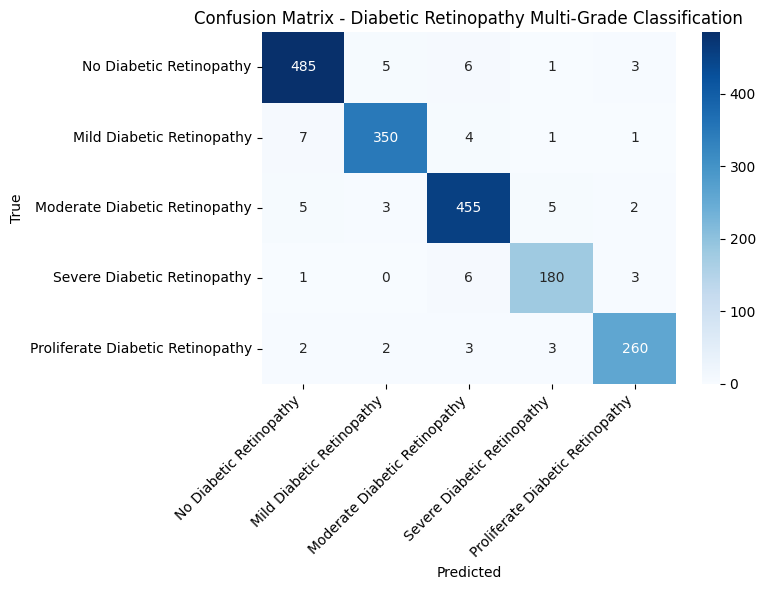

In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = [
    "No Diabetic Retinopathy",
    "Mild Diabetic Retinopathy",
    "Moderate Diabetic Retinopathy",
    "Severe Diabetic Retinopathy",
    "Proliferate Diabetic Retinopathy"
]

# === Print metrics
print("📊 Classification Report:")
print(classification_report(y_val, y_pred, target_names=class_labels))

print("✅ Accuracy:", accuracy_score(y_val, y_pred))
print("✅ Precision:", precision_score(y_val, y_pred, average='weighted'))
print("✅ Recall:", recall_score(y_val, y_pred, average='weighted'))
print("✅ F1 Score:", f1_score(y_val, y_pred, average='weighted'))

# === Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (XGBoost Fusion)")
plt.tight_layout()
plt.savefig('./combinedOUTPUT_dir/xgb_confusion_heatmap.png')
plt.show()


# #############################
# ROC - AUC METRICS AND CURVES
# #############################

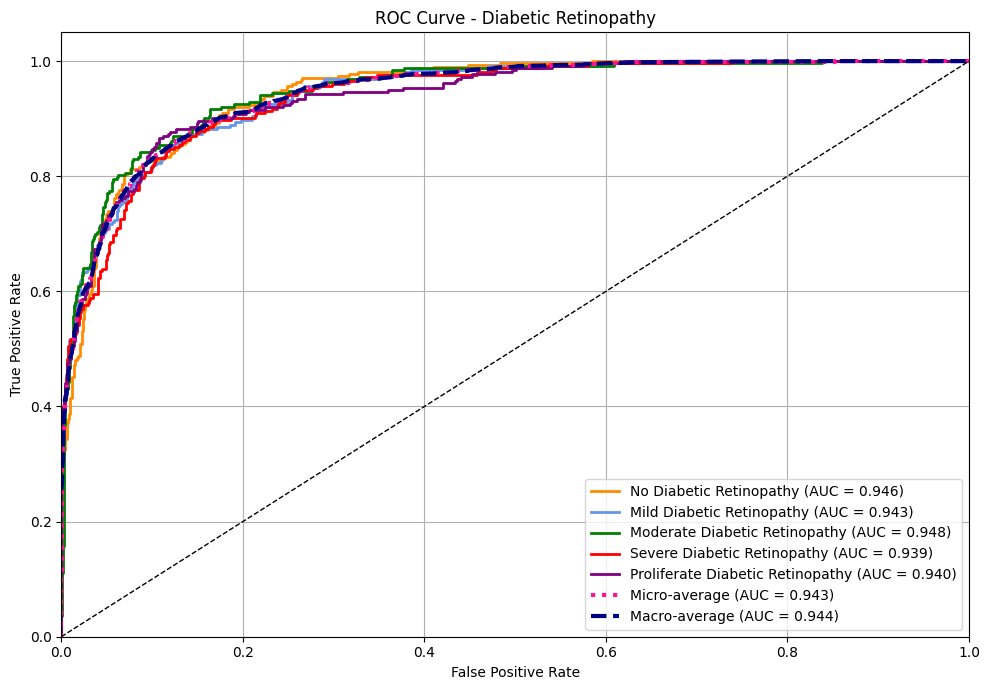

✅ Macro AUC: 0.9438
✅ Micro AUC: 0.9434


In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# === One-hot encode y_true and y_pred for ROC ===
n_classes = len(class_names)
y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))
y_pred_prob = clf.predict_proba(X_val)

# === ROC AUC scores ===
macro_auc = roc_auc_score(y_val_bin, y_pred_prob, average="macro")
micro_auc = roc_auc_score(y_val_bin, y_pred_prob, average="micro")
print(f"✅ Macro AUC: {macro_auc:.4f}")
print(f"✅ Micro AUC: {micro_auc:.4f}")

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} ({class_names[i]}) ROC AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost Fusion)')
plt.legend(loc="lower right")

# Save ROC curve image
roc_path = './combinedOUTPUT_dir/xgb_roc_curve.png'
plt.tight_layout()
plt.savefig(roc_path)
plt.show()

print(f"📌 ROC curve saved to: {roc_path}")


# ########################
# SINGLE IMAGE PREDICTION
# ########################

In [6]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
import joblib

# === CONFIG ===
IMG_PATH = 'augmented_resized_V2/val/4/78b3f819dcc5-600-FS.jpg'
IMG_SIZE = 384

cnn_model_paths = {
    'b3': './combinedOUTPUT_dir/effnetb3_img384_best.h5',
    'resnet': './combinedOUTPUT_dir/resnet50_img384_best.h5',
    'dense': './combinedOUTPUT_dir/densenet121_img384_best.h5'
}

xgb_model_path = './combinedOUTPUT_dir/xgb_fusion_model.joblib'

class_labels = [
    "No Diabetic Retinopathy",
    "Mild Diabetic Retinopathy",
    "Moderate Diabetic Retinopathy",
    "Severe Diabetic Retinopathy",
    "Proliferate Diabetic Retinopathy"
]

def preprocess_single(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img) / 255.0
    arr_exp = np.expand_dims(arr, axis=0)
    flipped = np.expand_dims(np.flip(arr, axis=1), axis=0)  # horizontal flip
    return arr_exp, flipped

def extract_tta_features(model_path, img, flipped_img):
    model = load_model(model_path)
    feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    f1 = feature_model.predict(img, verbose=0)
    f2 = feature_model.predict(flipped_img, verbose=0)
    return (f1 + f2) / 2

# === Preprocess image
img_normal, img_flipped = preprocess_single(IMG_PATH)

# === Extract features from all models
features = []
for name, path in cnn_model_paths.items():
    f = extract_tta_features(path, img_normal, img_flipped)
    features.append(f)

# === Concatenate all features
X_input = np.concatenate(features, axis=1)

# === Load XGBoost model and predict
clf = joblib.load(xgb_model_path)
y_pred = clf.predict(X_input)[0]

# === Output
print(f"📸 Predicted class index: {y_pred}")
print(f"🧾 Diagnosis: {class_labels[y_pred]}")


2025-04-14 04:04:35.124486: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.205 = (f32[1,288,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,288,48,48]{3,2,1,0} %bitcast.13110, f32[288,1,5,5]{3,2,1,0} %bitcast.13117), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=288, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_3_1/block3b_dwconv_1/depthwise" source_file="/home/rithish0227/jaienv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-14 04:04:35.677949: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.572377266s
Trying algorit

📸 Predicted class index: 4
🧾 Diagnosis: Proliferate Diabetic Retinopathy
